<div>
<a href="http://www.music-processing.de/"><img style="float:left;" src="../data/FMP_Teaser_Cover.png" width=40% alt="FMP"></a>
<a href="https://www.audiolabs-erlangen.de"><img src="../data/Logo_AudioLabs_Long.png" width=59% style="float: right;" alt="AudioLabs"></a>
</div>

<div>
<a href="../C2/C2.html"><img src="../data/C2_nav.png" width="100"  style="float:right;" alt="C2"></a>
<h1>Digital Signals: Sampling</h1> 
</div>

<br/>

<p>
Analog signals have a continuous range of values in both time and amplitude, which generally leads to an infinite number of values. Since a computer can only store and process a finite number of values, one has to convert the waveform into some <strong>discrete</strong> representation&mdash;a process commonly referred to as <strong>digitization</strong>. The most common approach for digitizing audio signals consists of two steps called <strong>sampling</strong> and <strong>quantization</strong>. In this notebook, following Section 2.2.2.1 of  <a href="http://www.music-processing.de/">[Müller, FMP, Springer 2015]</a>, we explain the concept of sampling in more detail.
</p> 

## Sampling

In signal processing, the term **sampling** refers to the process of reducing a **continuous-time** (CT) signal to a **discrete-time** (DT) signal, which is defined only on a discrete subset of the time axis. By means of a suitable encoding, one often assumes that this discrete set is a subset $I$ of the set $\mathbb{Z}$ of integers. Then a DT-signal is defined to be a function $x\colon I\to\mathbb{R}$, where the domain $I$ corresponds to points in time. Since one can extend any DT-signal from the domain $I$ to the domain $\mathbb{Z}$ simply by setting all values to zeros for points in $\mathbb{Z}\setminus I$, we may assume $I=\mathbb{Z}$.

The most common sampling procedure to transform a CT-signal $f\colon\mathbb{R}\to\mathbb{R}$ into a DT-signal $x\colon\mathbb{Z}\to\mathbb{R}$ is known as **equidistant sampling**. Fixing a positive real number $T>0$, the DT-signal $x$ is obtained by setting 

\begin{equation}
   x(n):= f(n \cdot T)
\end{equation}

for $n\in\mathbb{Z}$. The value $x(n)$ is called the **sample** taken at time $t=n\cdot T$ of the original analog signal $f$. In short, this procedure is also called **$T$-sampling**. The number $T$ is referred to as the **sampling period** and the inverse $F_\mathrm{s}:=1/T$ as the **sampling rate**. The sampling rate specifies the number of samples per second and is measured in Hertz (Hz). 

In the following code cell, we start with a CT-signal $f$ that is defined via linear interpolation of a DT-signal sampled at a high sampling rate. In the plot, this CT-signal is shown as black curve. Applying equidistant sampling, we obtain the DT-signal $x$ visualized as the red stem plot.

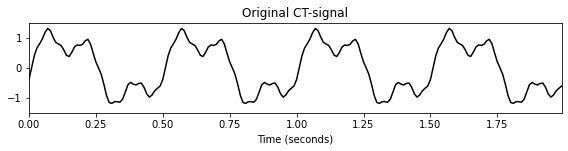

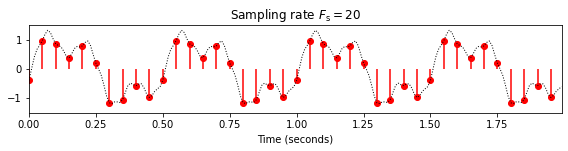

In [1]:
import numpy as np
from scipy.interpolate import interp1d
from matplotlib import pyplot as plt
%matplotlib inline

def generate_function(Fs, dur=1):
    """Generate example function

    Notebook: C2/C2S2_DigitalSignalSampling.ipynb

    Args:
        Fs (scalar): Sampling rate
        dur (float): Duration (in seconds) of signal to be generated (Default value = 1)

    Returns:
        x (np.ndarray): Signal
        t (np.ndarray): Time axis (in seconds)
    """
    N = int(Fs * dur)
    t = np.arange(N) / Fs
    x = 1 * np.sin(2 * np.pi * (2 * t - 0))
    x += 0.5 * np.sin(2 * np.pi * (6 * t - 0.1))
    x += 0.1 * np.sin(2 * np.pi * (20 * t - 0.2))
    return x, t

def sampling_equidistant(x_1, t_1, Fs_2, dur=None):
    """Equidistant sampling of interpolated signal

    Notebook: C2/C2S2_DigitalSignalSampling.ipynb

    Args:
        x_1 (np.ndarray): Signal to be interpolated and sampled
        t_1 (np.ndarray): Time axis (in seconds) of x_1
        Fs_2 (scalar): Sampling rate used for equidistant sampling
        dur (float): Duration (in seconds) of sampled signal (Default value = None)

    Returns:
        x (np.ndarray): Sampled signal
        t (np.ndarray): Time axis (in seconds) of sampled signal
    """
    if dur is None:
        dur = len(t_1) * t_1[1]
    N = int(Fs_2 * dur)
    t_2 = np.arange(N) / Fs_2
    x_2 = interp1d(t_1, x_1, kind='linear', fill_value='extrapolate')(t_2)
    return x_2, t_2
    
Fs_1 = 100
x_1, t_1 = generate_function(Fs=Fs_1, dur=2)

Fs_2 = 20
x_2, t_2 = sampling_equidistant(x_1, t_1, Fs_2)
    
plt.figure(figsize=(8, 2.2))
plt.plot(t_1, x_1, 'k')
plt.title('Original CT-signal')
plt.xlabel('Time (seconds)')
plt.ylim([-1.5, 1.5])
plt.xlim([t_1[0], t_1[-1]])
plt.tight_layout()

plt.figure(figsize=(8, 2.2))
plt.stem(t_2, x_2, linefmt='r', markerfmt='ro', basefmt='None', use_line_collection=True)
plt.plot(t_1, x_1, 'k', linewidth=1, linestyle='dotted')
plt.title(r'Sampling rate $F_\mathrm{s} = %.0f$'%Fs_2)
plt.xlabel('Time (seconds)')
plt.ylim([-1.5, 1.5])
plt.xlim([t_1[0], t_1[-1]])
plt.tight_layout()

## Aliasing

In general, sampling is a **lossy** operation in the sense that information is lost in this process and that the original CT-signal cannot be recovered from its sampled version. Only if the CT-signal has additional properties in terms of its frequency spectrum (it needs to be **bandlimited**), a perfect reconstruction is possible. This is the assertion of the famous **sampling theorem**, which we explain in more detail at the end of this notebook. The sampling theorem also shows how the original CT-signal can be reconstructed by superimposing suitably shifted $\mathrm{sinc}$-functions weighted by the samples of the DT-signal.

Without additional properties, sampling may cause an effect known as **aliasing** where certain frequency components of the signal become indistinguishable. This effect is illustrated by the following figure. Using a high sampling rate, the original CT-signal can be reconstructed with high accuracy. However, when decreasing the sampling rate, the higher-frequency components are not captured well and only a coarse approximation of the original signal remains. This phenomenon is demonstrated by the following example.

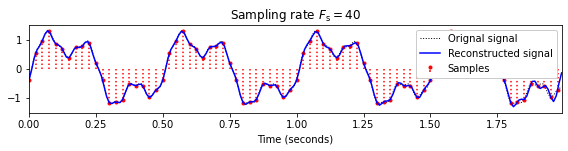

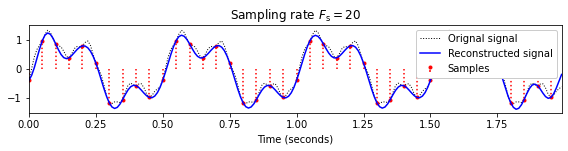

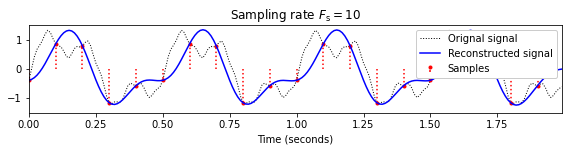

In [2]:
def reconstruction_sinc(x, t, t_sinc):
    """Reconstruction from sampled signal using sinc-functions

    Notebook: C2/C2S2_DigitalSignalSampling.ipynb

    Args:
        x (np.ndarray): Sampled signal
        t (np.ndarray): Equidistant discrete time axis (in seconds) of x
        t_sinc (np.ndarray): Equidistant discrete time axis (in seconds) of signal to be reconstructed

    Returns:
        x_sinc (np.ndarray): Reconstructed signal having time axis t_sinc
    """
    Fs = 1 / t[1]
    x_sinc = np.zeros(len(t_sinc))
    for n in range(0, len(t)):
        x_sinc += x[n] * np.sinc(Fs * t_sinc - n)
    return x_sinc

def plot_signal_reconstructed(t_1, x_1, t_2, x_2, t_sinc, x_sinc):
    plt.figure(figsize=(8, 2.2))
    plt.plot(t_1, x_1, 'k', linewidth=1, linestyle='dotted', label='Orignal signal')
    plt.stem(t_2, x_2, linefmt='r:', markerfmt='r.', basefmt='None', label='Samples', use_line_collection=True)
    plt.plot(t_1, x_sinc, 'b', label='Reconstructed signal')
    plt.title(r'Sampling rate $F_\mathrm{s} = %.0f$'%(1/t_2[1]))
    plt.xlabel('Time (seconds)')
    plt.ylim([-1.5, 1.5])
    plt.xlim([t_1[0], t_1[-1]])
    plt.legend(loc='upper right', framealpha=1)
    plt.tight_layout()
    plt.show()

Fs_2 = 40
x_2, t_2 = sampling_equidistant(x_1, t_1, Fs_2)
t_sinc = t_1
x_sinc = reconstruction_sinc(x_2, t_2, t_sinc)
plot_signal_reconstructed(t_1, x_1, t_2, x_2, t_sinc, x_sinc);

Fs_2 = 20
x_2, t_2 = sampling_equidistant(x_1, t_1, Fs_2)
t_sinc = t_1
x_sinc = reconstruction_sinc(x_2, t_2, t_sinc)
plot_signal_reconstructed(t_1, x_1, t_2, x_2, t_sinc, x_sinc);

Fs_2 = 10
x_2, t_2 = sampling_equidistant(x_1, t_1, Fs_2)
t_sinc = t_1
x_sinc = reconstruction_sinc(x_2, t_2, t_sinc)
plot_signal_reconstructed(t_1, x_1, t_2, x_2, t_sinc, x_sinc);

Aliasing effects occur also in other areas such as the visual domain. One famous example is the **wagon-wheel effect**, where a wheel appears to rotate at a slower speed or even backwards when the speed is actually increasing.

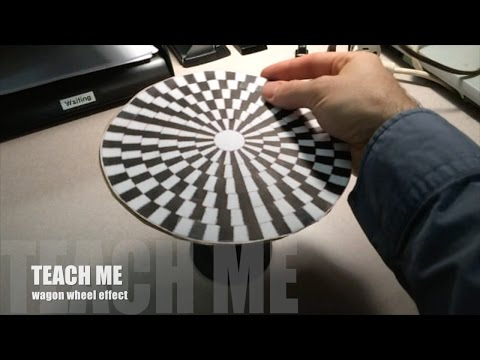

In [3]:
import IPython.display as ipd
ipd.display(ipd.YouTubeVideo('QOwzkND_ooU', width=600, height=450))

The next example indicates how aliasing effects the sound quality. We start with a music signal at a high sampling rate ($F_\mathrm{s}=8192$ Hz), which is then successively reduced by a factor of two.

In [4]:
import os
import IPython.display as ipd
import librosa
import scipy.signal

path_filename_wav = os.path.join('..', 'data', 'C2', 'FMP_C2_Sampling_C-major-scale.wav')
x, Fs = librosa.load(path_filename_wav, sr=8000)
Fs_orig = Fs
len_orig = len(x)
for i in range(5):
    print('Sampling rate Fs = %s; Number of samples = %s' % (Fs, len(x)), flush=True)
    # ipd.display(ipd.Audio(data=x, rate=Fs))
    # Some web browsers do not support arbitray sample rates. 
    # Therefore, the previous output may work for some web rowers. 
    # This is a work around:  
    x_play = scipy.signal.resample(x, len_orig)
    ipd.display(ipd.Audio(data=x_play, rate=Fs_orig))
    Fs = Fs // 2
    x = x[::2]

Sampling rate Fs = 8000; Number of samples = 26496


Sampling rate Fs = 4000; Number of samples = 13248


Sampling rate Fs = 2000; Number of samples = 6624


Sampling rate Fs = 1000; Number of samples = 3312


Sampling rate Fs = 500; Number of samples = 1656


## Sampling Theorem

The **sampling theorem**, which is often associated with the names Harry Nyquist and Claude Shannon, states that a continuous-time (CT) signal that is bandlimited can be reconstructed perfectly under certain conditions. More precisely, a CT-signal $f\in L^2(\mathbb{R})$ is called **$\Omega$-bandlimited** if the Fourier transform $\hat{f}$ vanishes for $|\omega|>\Omega$ (i.e., $\hat{f}(\omega) = 0$ for $|\omega|>\Omega$). Let $f\in L^2(\mathbb{R})$ be an $\Omega$-bandlimited function and let $x$ be the $T$-sampled version of $f$ with $T:=1/(2\Omega)$ (i.e., $x(n)=f(nT)$, $n\in\mathbb{Z}$). Then $f$ can be reconstructed from $x$ by

$$
 f(t)=\sum_{n\in\mathbb{Z}}x(n)\mathrm{sinc}\left(\frac{t-nT}{T}\right)
 =\sum_{n\in\mathbb{Z}}f\left(\frac{n}{2\Omega}\right) \mathrm{sinc}\left(2\Omega t-n\right),
$$

where the $\mathrm{sinc}$-function is defined as

\begin{equation}
    \mathrm{sinc}(t):=\left\{\begin{array}{ll}
    \frac{\sin \pi t}{\pi t},&\mbox{ if $t\not= 0$,}\\
    1,&\mbox{ if $t= 0$.}
\end{array}\right.
\end{equation}

In other words, the CT-signal $f$ can be perfectly reconstructed from the DT-signal obtained by equidistant sampling if the bandlimit is no greater than half the sampling rate. This reconstruction based on the $\mathrm{sinc}$-function has been used in the function `reconstruction_sinc`.

<div class="alert" style="background-color:#F5F5F5; border-color:#C8C8C8">
<strong>Acknowledgment:</strong> This notebook was created by <a href="https://www.audiolabs-erlangen.de/fau/professor/mueller">Meinard Müller</a>.
</div>  

<table style="border:none">
<tr style="border:none">
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C0/C0.html"><img src="../data/C0_nav.png" style="height:50px" alt="C0"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C1/C1.html"><img src="../data/C1_nav.png" style="height:50px" alt="C1"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C2/C2.html"><img src="../data/C2_nav.png" style="height:50px" alt="C2"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C3/C3.html"><img src="../data/C3_nav.png" style="height:50px" alt="C3"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C4/C4.html"><img src="../data/C4_nav.png" style="height:50px" alt="C4"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C5/C5.html"><img src="../data/C5_nav.png" style="height:50px" alt="C5"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C6/C6.html"><img src="../data/C6_nav.png" style="height:50px" alt="C6"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C7/C7.html"><img src="../data/C7_nav.png" style="height:50px" alt="C7"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C8/C8.html"><img src="../data/C8_nav.png" style="height:50px" alt="C8"></a></td>
</tr>
</table>